## Deep Learning Multiclass Challenge (CAD Project)

Author: **Muhammad Zain Amin**
<br>
Erasmus Mundus Joint Master Degree in Medical Imaging and Applications (MAIA)
<br>
University of Girona, Spain

#### Libraries

In [ ]:
import copy
import time
import sys
import logging
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageOps
from typing import Optional, Sequence

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from skimage import io

#### Import Functions and Classes

In [20]:
from imshow import imshow
from visualize_model import visualize_model
from focal_loss import FocalLoss
from train_model import train_model
from test_model import test_model
from plot_confusion_matrix import plot_confusion_matrix
from plot_roc import plot_roc
from Imbalanced_Dataset_Sampler import ImbalancedDatasetSampler 
from Challenge_2_Dataset import Challenge2Dataset
from Data_Samples import get_samples_count
from models import ModelFactory

#### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Dataset Directories

In [ ]:
# Image directories
train_img_folder = '/content/drive/MyDrive/CAD/Dataset/train/train'
val_img_folder = '/content/drive/MyDrive/CAD/Dataset/val/val'
test_img_folder = '/content/drive/MyDrive/CAD/Dataset/test'

# CSV paths
train_csv_path = '/content/drive/MyDrive/CAD/Dataset/train_labels.csv'
val_csv_path = '/content/drive/MyDrive/CAD/Dataset/val_labels.csv'
test_csv_path = '/content/drive/MyDrive/CAD/Dataset/test_ids.csv'

#### Parameters

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
NEW_SIZE = 256
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
NUM_WORKERS = 2
MU = [0.6138, 0.5056, 0.4985]
STD = [0.1611, 0.1672, 0.1764]

#### Data Transformations

In [ ]:
img_transforms = transforms.Compose([
                                      transforms.Resize(NEW_SIZE+4),
                                      transforms.CenterCrop(NEW_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean= MU, std=STD)
                                  ])

In [ ]:
dataset_train = Challenge2Dataset(csv_file=train_csv_path,
                             image_folder= train_img_folder,
                             img_transform = img_transforms,
                             augment = True)

In [ ]:
dataset_val = Challenge2Dataset(csv_file=val_csv_path,
                            image_folder= val_img_folder,
                            img_transform = img_transforms,
                            augment=False)


#### Data Loaders

In [ ]:
y = dataset_train.get_labels()
class_weights= class_weight.compute_class_weight(class_weight = 'balanced', classes= np.unique(y), y= np.array(y))
class_weights =  torch.tensor(class_weights).float().to(DEVICE)

In [ ]:
# Balanced training dataloader
mean_samples = get_samples_count(dataset_train.get_labels(), 'mean') 
data_sampler = ImbalancedDatasetSampler(dataset_train, indices=None, num_samples=mean_samples, replacement = True)
train_loader_balanced = DataLoader(dataset_train, sampler=data_sampler, num_workers=NUM_WORKERS,
                             batch_size=TRAIN_BATCH_SIZE)

In [ ]:
val_loader_shuff = DataLoader(dataset_val, batch_size=8, num_workers=NUM_WORKERS, shuffle=True)

In [ ]:
# dataloaders with the original number of samples in the dataset
train_loader = DataLoader(dataset_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS)


In [ ]:
dataloaders = {"train": train_loader,"val": val_loader}
dataloaders_balanced = {"train": train_loader_balanced,"val": val_loader}

# Training and Results

#### EfficientNet B1 Model

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/CAD/EfficientNet/efficientnet_ce.txt", level=logging.INFO, format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/CAD/EfficientNet'

In [ ]:
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-6
model_factory = ModelFactory()
efficientnet = model_factory.make_efficientnet(True, DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet.parameters(), lr = LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:14<00:00, 2.23MB/s]


In [ ]:
logging.info('Model: EfficientNet, LR: 1e-4, LR patience = 7, loss: CE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-6, with sampling')

Model: EfficientNet, LR: 1e-4, LR patience = 7, loss: CE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-6, with sampling


In [ ]:
#number of samples in each set
dataset_sizes = {'train': mean_samples,'val':len(dataset_val)}

In [ ]:
checkpoint_p = '/content/drive/MyDrive/CAD/efficientnet_ce_sampling.pth'
efficientnet = train_model(efficientnet, dataloaders_balanced, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.89it/s]

train epoch 1 : loss : 0.7903, acc: 0.6421, kappa: 0.4626



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 1 : loss : 0.4863, acc: 0.8024, kappa: 0.6642



Epoch 2/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.92it/s]

train epoch 2 : loss : 0.5632, acc: 0.7647, kappa: 0.6470



100%|██████████| 20/20 [00:24<00:00,  1.20s/it]

val epoch 2 : loss : 0.3970, acc: 0.8441, kappa: 0.7315



Epoch 3/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]

train epoch 3 : loss : 0.4681, acc: 0.8121, kappa: 0.7180



100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

val epoch 3 : loss : 0.3989, acc: 0.8496, kappa: 0.7466



Epoch 4/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.87it/s]

train epoch 4 : loss : 0.4136, acc: 0.8392, kappa: 0.7588



100%|██████████| 20/20 [00:22<00:00,  1.10s/it]

val epoch 4 : loss : 0.3027, acc: 0.8929, kappa: 0.8125



Epoch 5/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.89it/s]

train epoch 5 : loss : 0.3795, acc: 0.8530, kappa: 0.7795



100%|██████████| 20/20 [00:22<00:00,  1.15s/it]

val epoch 5 : loss : 0.2935, acc: 0.9071, kappa: 0.8374



Epoch 6/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.92it/s]

train epoch 6 : loss : 0.3309, acc: 0.8737, kappa: 0.8105



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 6 : loss : 0.3306, acc: 0.8850, kappa: 0.8020



Epoch 7/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.95it/s]

train epoch 7 : loss : 0.2913, acc: 0.8888, kappa: 0.8332



100%|██████████| 20/20 [00:24<00:00,  1.20s/it]

val epoch 7 : loss : 0.3147, acc: 0.8953, kappa: 0.8196



Epoch 8/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.94it/s]

train epoch 8 : loss : 0.2657, acc: 0.8985, kappa: 0.8476



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 8 : loss : 0.2628, acc: 0.9087, kappa: 0.8398



Epoch 9/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.90it/s]

train epoch 9 : loss : 0.2462, acc: 0.9115, kappa: 0.8672



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

val epoch 9 : loss : 0.2778, acc: 0.9047, kappa: 0.8324



Epoch 10/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.89it/s]

train epoch 10 : loss : 0.2379, acc: 0.9118, kappa: 0.8677



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

val epoch 10 : loss : 0.2934, acc: 0.9087, kappa: 0.8409



Epoch 11/100
---------------


100%|██████████| 318/318 [01:51<00:00,  2.85it/s]

train epoch 11 : loss : 0.2309, acc: 0.9160, kappa: 0.8739



100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

val epoch 11 : loss : 0.2197, acc: 0.9283, kappa: 0.8724



Epoch 12/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.90it/s]

train epoch 12 : loss : 0.2065, acc: 0.9235, kappa: 0.8851



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 12 : loss : 0.2278, acc: 0.9244, kappa: 0.8663



Epoch 13/100
---------------


100%|██████████| 318/318 [01:51<00:00,  2.86it/s]

train epoch 13 : loss : 0.1770, acc: 0.9347, kappa: 0.9020



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

val epoch 13 : loss : 0.2091, acc: 0.9394, kappa: 0.8912



Epoch 14/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.87it/s]


train epoch 14 : loss : 0.1740, acc: 0.9376, kappa: 0.9064


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

val epoch 14 : loss : 0.2260, acc: 0.9260, kappa: 0.8689



Epoch 15/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]

train epoch 15 : loss : 0.1543, acc: 0.9414, kappa: 0.9120



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 15 : loss : 0.2658, acc: 0.9197, kappa: 0.8566



Epoch 16/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]

train epoch 16 : loss : 0.1576, acc: 0.9402, kappa: 0.9103



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 16 : loss : 0.2439, acc: 0.9268, kappa: 0.8696



Epoch 17/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.94it/s]

train epoch 17 : loss : 0.1324, acc: 0.9498, kappa: 0.9247



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 17 : loss : 0.2096, acc: 0.9402, kappa: 0.8933



Epoch 18/100
---------------


100%|██████████| 318/318 [01:51<00:00,  2.84it/s]

train epoch 18 : loss : 0.1305, acc: 0.9536, kappa: 0.9303



100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

val epoch 18 : loss : 0.2057, acc: 0.9409, kappa: 0.8936



Epoch 19/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.88it/s]

train epoch 19 : loss : 0.1276, acc: 0.9551, kappa: 0.9327



100%|██████████| 20/20 [00:22<00:00,  1.15s/it]

val epoch 19 : loss : 0.2008, acc: 0.9457, kappa: 0.9029



Epoch 20/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]

train epoch 20 : loss : 0.1292, acc: 0.9555, kappa: 0.9333



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 20 : loss : 0.2143, acc: 0.9394, kappa: 0.8916



Epoch 21/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]

train epoch 21 : loss : 0.1120, acc: 0.9614, kappa: 0.9421



100%|██████████| 20/20 [00:24<00:00,  1.20s/it]

val epoch 21 : loss : 0.2236, acc: 0.9346, kappa: 0.8832



Epoch 22/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.92it/s]

train epoch 22 : loss : 0.1084, acc: 0.9597, kappa: 0.9395



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

val epoch 22 : loss : 0.2136, acc: 0.9433, kappa: 0.8987



Epoch 23/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.88it/s]

train epoch 23 : loss : 0.1140, acc: 0.9587, kappa: 0.9380



100%|██████████| 20/20 [00:21<00:00,  1.09s/it]

val epoch 23 : loss : 0.2209, acc: 0.9409, kappa: 0.8946



Epoch 24/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.88it/s]

train epoch 24 : loss : 0.1012, acc: 0.9636, kappa: 0.9454



100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

val epoch 24 : loss : 0.1881, acc: 0.9449, kappa: 0.9013



Epoch 25/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.90it/s]

train epoch 25 : loss : 0.1018, acc: 0.9640, kappa: 0.9460



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 25 : loss : 0.1951, acc: 0.9386, kappa: 0.8906



Epoch 26/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]

train epoch 26 : loss : 0.0898, acc: 0.9671, kappa: 0.9507



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 26 : loss : 0.1938, acc: 0.9402, kappa: 0.8924



Epoch 27/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.90it/s]

train epoch 27 : loss : 0.0914, acc: 0.9664, kappa: 0.9495



100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

val epoch 27 : loss : 0.2147, acc: 0.9417, kappa: 0.8969



Epoch 28/100
---------------


100%|██████████| 318/318 [01:51<00:00,  2.86it/s]

train epoch 28 : loss : 0.0853, acc: 0.9705, kappa: 0.9557



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

val epoch 28 : loss : 0.1990, acc: 0.9457, kappa: 0.9027



Epoch 29/100
---------------


100%|██████████| 318/318 [01:53<00:00,  2.80it/s]

train epoch 29 : loss : 0.0842, acc: 0.9715, kappa: 0.9572



100%|██████████| 20/20 [00:24<00:00,  1.20s/it]

val epoch 29 : loss : 0.1861, acc: 0.9425, kappa: 0.8966



Epoch 30/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.90it/s]

train epoch 30 : loss : 0.0736, acc: 0.9734, kappa: 0.9601



100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

val epoch 30 : loss : 0.1991, acc: 0.9425, kappa: 0.8973



Epoch 31/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.87it/s]

train epoch 31 : loss : 0.0782, acc: 0.9740, kappa: 0.9610



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

val epoch 31 : loss : 0.1942, acc: 0.9488, kappa: 0.9087



Epoch 32/100
---------------


100%|██████████| 318/318 [01:51<00:00,  2.85it/s]

train epoch 32 : loss : 0.0717, acc: 0.9740, kappa: 0.9610



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

val epoch 32 : loss : 0.1991, acc: 0.9441, kappa: 0.8994



Epoch 33/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]

train epoch 33 : loss : 0.0701, acc: 0.9736, kappa: 0.9604



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 33 : loss : 0.1930, acc: 0.9457, kappa: 0.9032



Epoch 34/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.89it/s]


train epoch 34 : loss : 0.0717, acc: 0.9742, kappa: 0.9613


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 34 : loss : 0.1966, acc: 0.9512, kappa: 0.9125



Epoch 35/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.90it/s]

train epoch 35 : loss : 0.0664, acc: 0.9776, kappa: 0.9663



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

val epoch 35 : loss : 0.1872, acc: 0.9496, kappa: 0.9095



Epoch 36/100
---------------


100%|██████████| 318/318 [01:51<00:00,  2.85it/s]

train epoch 36 : loss : 0.0639, acc: 0.9764, kappa: 0.9646



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

val epoch 36 : loss : 0.2068, acc: 0.9386, kappa: 0.8911



Epoch 37/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.90it/s]

train epoch 37 : loss : 0.0698, acc: 0.9746, kappa: 0.9619



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 37 : loss : 0.2192, acc: 0.9331, kappa: 0.8814



Epoch 38/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.94it/s]

train epoch 38 : loss : 0.0612, acc: 0.9776, kappa: 0.9663



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 38 : loss : 0.1922, acc: 0.9394, kappa: 0.8917



Epoch 39/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.94it/s]

train epoch 39 : loss : 0.0508, acc: 0.9850, kappa: 0.9776



100%|██████████| 20/20 [00:24<00:00,  1.20s/it]

val epoch 39 : loss : 0.1782, acc: 0.9465, kappa: 0.9040



Epoch 40/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.88it/s]


train epoch 40 : loss : 0.0470, acc: 0.9831, kappa: 0.9746


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

val epoch 40 : loss : 0.1820, acc: 0.9425, kappa: 0.8972



Epoch 41/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.88it/s]

train epoch 41 : loss : 0.0497, acc: 0.9837, kappa: 0.9755



100%|██████████| 20/20 [00:21<00:00,  1.10s/it]

val epoch 41 : loss : 0.1779, acc: 0.9457, kappa: 0.9029



Epoch 42/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.89it/s]

train epoch 42 : loss : 0.0435, acc: 0.9874, kappa: 0.9811



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

val epoch 42 : loss : 0.1734, acc: 0.9449, kappa: 0.9013



Epoch 43/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]

train epoch 43 : loss : 0.0446, acc: 0.9839, kappa: 0.9758



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 43 : loss : 0.1808, acc: 0.9472, kappa: 0.9057



Epoch 44/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.96it/s]

train epoch 44 : loss : 0.0440, acc: 0.9860, kappa: 0.9790



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 44 : loss : 0.1732, acc: 0.9449, kappa: 0.9015



Epoch 45/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.94it/s]

train epoch 45 : loss : 0.0435, acc: 0.9856, kappa: 0.9784



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 45 : loss : 0.1660, acc: 0.9512, kappa: 0.9122



Epoch 46/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]

train epoch 46 : loss : 0.0405, acc: 0.9847, kappa: 0.9770



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 46 : loss : 0.1718, acc: 0.9512, kappa: 0.9125



Epoch 47/100
---------------


100%|██████████| 318/318 [01:51<00:00,  2.86it/s]

train epoch 47 : loss : 0.0425, acc: 0.9850, kappa: 0.9776



100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

val epoch 47 : loss : 0.1670, acc: 0.9504, kappa: 0.9110



Epoch 48/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.88it/s]


train epoch 48 : loss : 0.0404, acc: 0.9870, kappa: 0.9805


100%|██████████| 20/20 [00:22<00:00,  1.15s/it]

val epoch 48 : loss : 0.1627, acc: 0.9520, kappa: 0.9139



Epoch 49/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]

train epoch 49 : loss : 0.0369, acc: 0.9870, kappa: 0.9805



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 49 : loss : 0.1685, acc: 0.9520, kappa: 0.9140



Epoch 50/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]


train epoch 50 : loss : 0.0344, acc: 0.9892, kappa: 0.9838


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

val epoch 50 : loss : 0.1694, acc: 0.9480, kappa: 0.9070



Epoch 51/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.92it/s]


train epoch 51 : loss : 0.0393, acc: 0.9860, kappa: 0.9790


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

val epoch 51 : loss : 0.1694, acc: 0.9496, kappa: 0.9097



Epoch 52/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]

train epoch 52 : loss : 0.0353, acc: 0.9890, kappa: 0.9835



100%|██████████| 20/20 [00:22<00:00,  1.15s/it]

val epoch 52 : loss : 0.1700, acc: 0.9520, kappa: 0.9136



Epoch 53/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.87it/s]

train epoch 53 : loss : 0.0373, acc: 0.9870, kappa: 0.9805



100%|██████████| 20/20 [00:22<00:00,  1.10s/it]

val epoch 53 : loss : 0.1656, acc: 0.9488, kappa: 0.9083



Epoch 54/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.88it/s]

train epoch 54 : loss : 0.0341, acc: 0.9870, kappa: 0.9805



100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

val epoch 54 : loss : 0.1670, acc: 0.9488, kappa: 0.9083



Epoch 55/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.97it/s]

train epoch 55 : loss : 0.0337, acc: 0.9898, kappa: 0.9846



100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


val epoch 55 : loss : 0.1641, acc: 0.9535, kappa: 0.9165

Epoch 56/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.96it/s]

train epoch 56 : loss : 0.0336, acc: 0.9882, kappa: 0.9823



100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

val epoch 56 : loss : 0.1699, acc: 0.9567, kappa: 0.9223



Epoch 57/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.94it/s]

train epoch 57 : loss : 0.0382, acc: 0.9886, kappa: 0.9829



100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

val epoch 57 : loss : 0.1703, acc: 0.9496, kappa: 0.9099



Epoch 58/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]

train epoch 58 : loss : 0.0330, acc: 0.9882, kappa: 0.9823



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

val epoch 58 : loss : 0.1669, acc: 0.9567, kappa: 0.9225



Epoch 59/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]

train epoch 59 : loss : 0.0343, acc: 0.9890, kappa: 0.9835



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

val epoch 59 : loss : 0.1582, acc: 0.9543, kappa: 0.9182



Epoch 60/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]


train epoch 60 : loss : 0.0351, acc: 0.9872, kappa: 0.9808


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

val epoch 60 : loss : 0.1657, acc: 0.9535, kappa: 0.9167



Epoch 61/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.88it/s]

train epoch 61 : loss : 0.0352, acc: 0.9876, kappa: 0.9814



100%|██████████| 20/20 [00:22<00:00,  1.10s/it]

val epoch 61 : loss : 0.1617, acc: 0.9543, kappa: 0.9182



Epoch 62/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.89it/s]


train epoch 62 : loss : 0.0328, acc: 0.9890, kappa: 0.9835


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


val epoch 62 : loss : 0.1695, acc: 0.9551, kappa: 0.9197

Epoch 63/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]

train epoch 63 : loss : 0.0388, acc: 0.9868, kappa: 0.9802



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

val epoch 63 : loss : 0.1647, acc: 0.9488, kappa: 0.9086



Epoch 64/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]

train epoch 64 : loss : 0.0339, acc: 0.9880, kappa: 0.9820



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

val epoch 64 : loss : 0.1644, acc: 0.9512, kappa: 0.9127



Epoch 65/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]

train epoch 65 : loss : 0.0302, acc: 0.9902, kappa: 0.9852



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 65 : loss : 0.1655, acc: 0.9543, kappa: 0.9183



Epoch 66/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.92it/s]

train epoch 66 : loss : 0.0321, acc: 0.9872, kappa: 0.9808



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 66 : loss : 0.1641, acc: 0.9528, kappa: 0.9154



Epoch 67/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.87it/s]

train epoch 67 : loss : 0.0303, acc: 0.9904, kappa: 0.9855



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

val epoch 67 : loss : 0.1642, acc: 0.9543, kappa: 0.9182



Epoch 68/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.89it/s]

train epoch 68 : loss : 0.0272, acc: 0.9894, kappa: 0.9841



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

val epoch 68 : loss : 0.1745, acc: 0.9512, kappa: 0.9128



Epoch 69/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.88it/s]

train epoch 69 : loss : 0.0350, acc: 0.9866, kappa: 0.9799



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

val epoch 69 : loss : 0.1685, acc: 0.9457, kappa: 0.9033



Epoch 70/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]

train epoch 70 : loss : 0.0354, acc: 0.9892, kappa: 0.9838



100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

val epoch 70 : loss : 0.1556, acc: 0.9512, kappa: 0.9124



Epoch 71/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.95it/s]

train epoch 71 : loss : 0.0324, acc: 0.9878, kappa: 0.9817



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 71 : loss : 0.1613, acc: 0.9520, kappa: 0.9141



Epoch 72/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.97it/s]


train epoch 72 : loss : 0.0307, acc: 0.9896, kappa: 0.9844


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 72 : loss : 0.1677, acc: 0.9520, kappa: 0.9140



Epoch 73/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.95it/s]

train epoch 73 : loss : 0.0333, acc: 0.9882, kappa: 0.9823



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 73 : loss : 0.1563, acc: 0.9559, kappa: 0.9208



Epoch 74/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.95it/s]

train epoch 74 : loss : 0.0263, acc: 0.9913, kappa: 0.9870



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 74 : loss : 0.1602, acc: 0.9606, kappa: 0.9293



Epoch 75/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.96it/s]

train epoch 75 : loss : 0.0325, acc: 0.9904, kappa: 0.9855



100%|██████████| 20/20 [00:24<00:00,  1.20s/it]

val epoch 75 : loss : 0.1624, acc: 0.9543, kappa: 0.9182



Epoch 76/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]

train epoch 76 : loss : 0.0278, acc: 0.9904, kappa: 0.9855



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

val epoch 76 : loss : 0.1658, acc: 0.9512, kappa: 0.9126



Epoch 77/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.95it/s]

train epoch 77 : loss : 0.0277, acc: 0.9913, kappa: 0.9870



100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

val epoch 77 : loss : 0.1702, acc: 0.9488, kappa: 0.9088



Epoch 78/100
---------------


100%|██████████| 318/318 [01:50<00:00,  2.88it/s]

train epoch 78 : loss : 0.0347, acc: 0.9886, kappa: 0.9829



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

val epoch 78 : loss : 0.1729, acc: 0.9512, kappa: 0.9129



Epoch 79/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]

train epoch 79 : loss : 0.0288, acc: 0.9902, kappa: 0.9852



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

val epoch 79 : loss : 0.1672, acc: 0.9528, kappa: 0.9154



Epoch 80/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.89it/s]

train epoch 80 : loss : 0.0289, acc: 0.9913, kappa: 0.9870



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


val epoch 80 : loss : 0.1587, acc: 0.9512, kappa: 0.9128

Epoch 81/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.93it/s]

train epoch 81 : loss : 0.0311, acc: 0.9890, kappa: 0.9835



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

val epoch 81 : loss : 0.1795, acc: 0.9441, kappa: 0.9006



Epoch 82/100
---------------


100%|██████████| 318/318 [01:46<00:00,  2.98it/s]

train epoch 82 : loss : 0.0330, acc: 0.9894, kappa: 0.9841



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

val epoch 82 : loss : 0.1654, acc: 0.9520, kappa: 0.9142



Epoch 83/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.95it/s]

train epoch 83 : loss : 0.0305, acc: 0.9898, kappa: 0.9846



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 83 : loss : 0.1608, acc: 0.9559, kappa: 0.9211


EARLY STOP AFTER 83 EPOCHS
Training complete in 184m 24s
Best val loss: 0.155566
Best val Kappa: 0.9293219357998308


#### Load the saved model

In [ ]:
eff_best_1 = model_factory.make_efficientnet(False, DEVICE)
eff_best_1.load_state_dict(torch.load('/content/drive/MyDrive/CAD/efficientnet_ce_sampling_best.pth'))

<All keys matched successfully>

In [ ]:
since = time.time()
eff_best_1.eval()
running_labels = []
running_preds = []
outputs_all = []

# Iterate over data.
with torch.no_grad():
    for batch in tqdm(val_loader):
        inputs = batch["image"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        outputs = eff_best_1(inputs)
        _, preds = torch.max(outputs, 1)
        running_labels = running_labels + labels.int().cpu().tolist()
        running_preds = running_preds + preds.int().cpu().tolist()
        probas = F.softmax(outputs, dim=1)
        outputs_all.append(probas.cpu().numpy())
    test_kappa = cohen_kappa_score(running_labels, running_preds)
    test_acc = accuracy_score(running_labels, running_preds)
    print(f'Test Acc: {test_acc:.4f}, kappa: {test_kappa:.4f}')
    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

100%|██████████| 20/20 [00:24<00:00,  1.20s/it]

Test Acc: 0.9606, kappa: 0.9293
Testing complete in 0m 24s


Confusion matrix, without normalization
[[658  11   9]
 [ 15 477   6]
 [  7   2  85]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

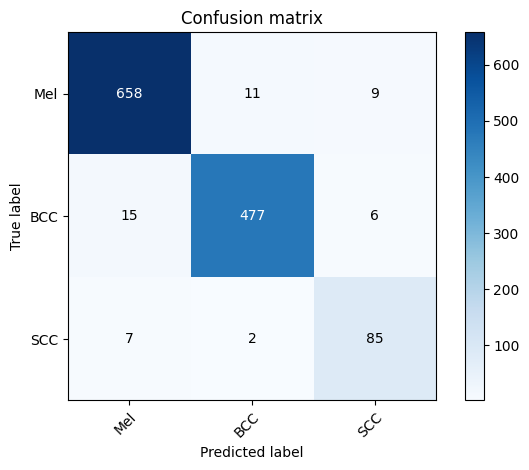

In [ ]:
plot_confusion_matrix(running_labels, running_preds, ['Mel', 'BCC', 'SCC'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

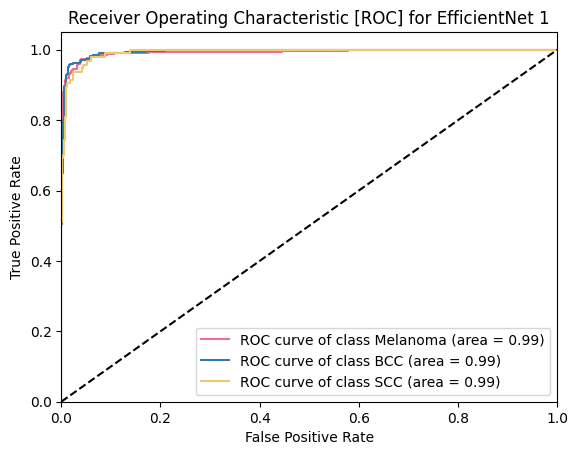

{0: 0.9929343059874033, 1: 0.9946105666188068, 2: 0.9929439861050803}

In [ ]:
probas = np.vstack(outputs_all)
plot_roc(running_labels, probas, True, 'EfficientNet 1')

In [ ]:
test_df = pd.read_csv(test_csv_path)
test_ids = []
test_preds = []
for i, row in test_df.iterrows():
  img_id = '/' + row['Image_ID'] 

  img_path = test_img_folder + img_id + '.jpg' 
  image = Image.open(img_path) 
  image = img_transforms(image).unsqueeze(0).to(DEVICE)

  outputs_1 = eff_best_1(image)
  outputs = outputs_1
  _, preds = torch.max(outputs, 1)
  test_preds = test_preds + preds.int().cpu().tolist()
  test_ids.append(img_id)
  print(f"Image {row['Image_ID']} done")

Image xxx01102 done
Image xxx01122 done
Image xxx01137 done
Image xxx01096 done
Image xxx01126 done
Image xxx01121 done
Image xxx01089 done
Image xxx01095 done
Image xxx01087 done
Image xxx01109 done
Image xxx01110 done
Image xxx01107 done
Image xxx01091 done
Image xxx01125 done
Image xxx01082 done
Image xxx01101 done
Image xxx01156 done
Image xxx01195 done
Image xxx01158 done
Image xxx01180 done
Image xxx01181 done
Image xxx01189 done
Image xxx01188 done
Image xxx01148 done
Image xxx01162 done
Image xxx01182 done
Image xxx01147 done
Image xxx01179 done
Image xxx01138 done
Image xxx01170 done
Image xxx01171 done
Image xxx01174 done
Image xxx01160 done
Image xxx01164 done
Image xxx01161 done
Image xxx01173 done
Image xxx01153 done
Image xxx01178 done
Image xxx01145 done
Image xxx01152 done
Image xxx01142 done
Image xxx01191 done
Image xxx01143 done
Image xxx01193 done
Image xxx01155 done
Image xxx01194 done
Image xxx01200 done
Image xxx01184 done
Image xxx01196 done
Image xxx01144 done


#### Save prediction in Excel File

In [ ]:
test_dict = {'img_id': test_ids, 'prediction': test_preds}
test_inf_df = pd.DataFrame(test_dict)
test_inf_df.to_csv('/content/drive/MyDrive/CAD/test_results_eff_1.csv')